In [1]:
from typing import Literal, Callable
from dataclasses import dataclass

import einops
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch import Tensor
from jaxtyping import Float
from rich import print, progress

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device is available")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device is available")
else:
    device = torch.device("cpu")
    print("MPS device is not available, using CPU")

MPS device is available

# Define Toy Model

In [2]:
def linear_lr(step, steps):
    return 1 - (step / steps)


def constant_lr(*_):
    return 1.0


def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))


@dataclass
class ToyModelConfig:
    # We optimize n_inst models in a single training loop to let us sweep over sparsity or importance
    # curves efficiently. You should treat the number of instances `n_inst` like a batch dimension,
    # but one which is built into our training setup. Ignore the latter 3 arguments for now, they'll
    # return in later exercises.
    n_inst: int
    n_features: int = 5
    d_hidden: int = 2
    n_correlated_pairs: int = 0
    n_anticorrelated_pairs: int = 0
    feat_mag_distn: Literal["unif", "normal"] = "unif"


class ToyModel(nn.Module):
    W: Float[Tensor, "inst d_hidden feats"]
    b_final: Float[Tensor, "inst feats"]

    def __init__(
        self,
        cfg: ToyModelConfig,
        feature_probability: float | Tensor,
        importance: float | Tensor = 1.0,
        device: torch.device = device,
    ):
        # init
        super(ToyModel, self).__init__()
        
        self.device = device
        self.cfg = cfg
        if isinstance(feature_probability, float):
            feature_probability = torch.tensor(feature_probability)
        self.feature_probability = feature_probability.to(device).broadcast_to(
            (cfg.n_inst, cfg.n_features)
        )
        if isinstance(importance, float):
            importance = torch.tensor(importance)
        self.importance = importance.to(device).broadcast_to(
            (cfg.n_inst, cfg.n_features)
        )

        self.W = nn.Parameter(
            nn.init.xavier_normal_(
                torch.empty(cfg.n_inst, cfg.d_hidden, cfg.n_features)
            )
        )
        self.b_final = nn.Parameter(torch.zeros((cfg.n_inst, cfg.n_features)))
        self.to(device)

    def forward(
        self, features: Float[Tensor, "... inst feats"]
    ) -> Float[Tensor, "... inst feats"]:
        h = einops.einsum(
            features, self.W, "... inst feats, inst hidden feats -> ... inst hidden"
        )  # (B, inst, 1, feats) * (B, inst, feats, hidden) -> (B, inst, 1, hidden) -> [(B, inst, hidden)]
        out = einops.einsum(
            h, self.W, "... inst hidden, inst hidden feats -> ... inst feats"
        )
        return F.relu(out + self.b_final)

    def generate_batch(self, batch_size: int) -> Float[Tensor, "batch inst feats"]:
        feat_mag = torch.rand(
            (batch_size, self.cfg.n_inst, self.cfg.n_features), device=self.device
        )
        feat_seed = torch.rand(
            (batch_size, self.cfg.n_inst, self.cfg.n_features), device=self.device
        )
        return torch.where(feat_seed <= self.feature_probability, feat_mag, 0.0)

    def calculate_loss(
        self,
        out: Float[Tensor, "batch inst feats"],
        batch: Float[Tensor, "batch inst feats"],
    ) -> Float[Tensor, ""]:
        error = self.importance * ((batch - out) ** 2)
        return einops.reduce(error, "batch inst feats -> inst", "mean").sum()

    def optimize(
        self,
        batch_size: int = 1024,
        steps: int = 5000,
        log_freq: int = 50,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
    ):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        with progress.Progress() as p_bar:
            task = p_bar.add_task("Training", total=steps)

            for step in range(steps):
                step_lr = lr * lr_scale(step, steps)  # Notice the multiplication by base lr
                for group in optimizer.param_groups:
                    group["lr"] = step_lr

                optimizer.zero_grad()
                batch = self.generate_batch(batch_size)
                out = self(batch)
                loss = self.calculate_loss(out, batch)
                loss.backward()
                optimizer.step()

                p_bar.update(task, advance=1)
                if step % log_freq == 0:
                    p_bar.update(task, description=f"Loss: {loss.item():.4f}")

# Train the Toy Model

In [3]:
cfg = ToyModelConfig(n_inst=8, n_features=5, d_hidden=2)

importance = 0.9 ** torch.arange(cfg.n_features)
feature_probability = 50 ** -torch.linspace(0, 1, cfg.n_inst)

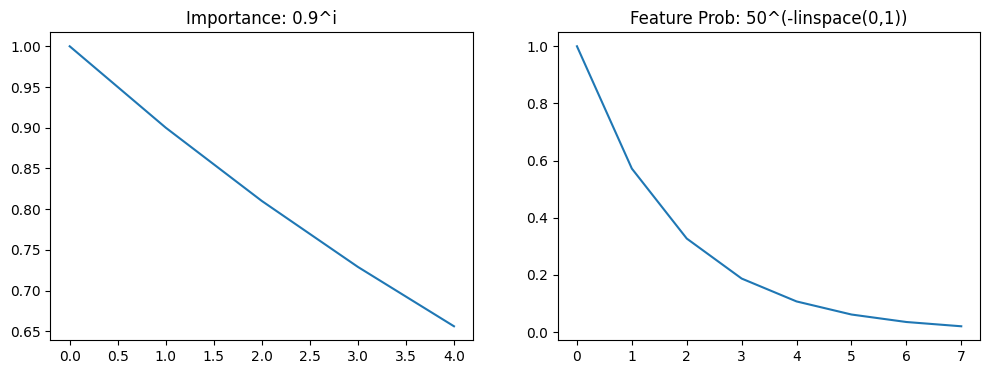

In [4]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); plt.plot(importance); plt.title('Importance: 0.9^i')  # noqa: E702
plt.subplot(1, 2, 2); plt.plot(feature_probability); plt.title('Feature Prob: 50^(-linspace(0,1))')  # noqa: E702
plt.show()

In [5]:
model = ToyModel(
    cfg=cfg,
    device=device,
    importance=importance[None, :],
    feature_probability=feature_probability[:, None],
)

model.optimize(
    batch_size=1024,
    lr=1e-3,
    steps=5000
)

Output()

In [6]:
def cast_element_to_nested_list(elem, shape: tuple):
    """
    Creates a nested list of shape `shape`, where every element is `elem`.
    Example: ("a", (2, 2)) -> [["a", "a"], ["a", "a"]]
    """
    if len(shape) == 0:
        return elem
    return [cast_element_to_nested_list(elem, shape[1:])] * shape[0]

def get_viridis(v: float) -> tuple[float, float, float]:
    r, g, b, a = plt.get_cmap("viridis")(v)
    return (r, g, b)

def plot_features_in_2d(
    W: Float[Tensor, "*inst d_hidden feats"] | list[Float[Tensor, "d_hidden feats"]],
    colors: Float[Tensor, "inst feats"] | list[str] | list[list[str]] | None = None,
    title: str | None = None,
    subplot_titles: list[str] | None = None,
    allow_different_limits_across_subplots: bool = False,
    n_rows: int | None = None,
):
    """
    Visualises superposition in 2D.

    If values is 4D, the first dimension is assumed to be timesteps, and an animation is created.
    """
    # Convert W into a list of 2D tensors, each of shape [feats, d_hidden=2]
    if isinstance(W, Tensor):
        if W.ndim == 2:
            W = W.unsqueeze(0)
        n_instances, d_hidden, n_feats = W.shape
        n_feats_list = []
        W = W.detach().cpu()
    else:
        # Hacky case which helps us deal with double descent exercises (this is never used outside of those exercises)
        assert all(w.ndim == 2 for w in W)
        n_feats_list = [w.shape[1] for w in W]
        n_feats = max(n_feats_list)
        n_instances = len(W)
        W = [w.detach().cpu() for w in W]

    W_list: list[Tensor] = [W_instance.T for W_instance in W]

    # Get some plot characteristics
    limits_per_instance = (
        [w.abs().max() * 1.1 for w in W_list]
        if allow_different_limits_across_subplots
        else [1.5 for _ in range(n_instances)]
    )
    linewidth, markersize = (1, 4) if (n_feats >= 25) else (1.5, 6)

    # Maybe break onto multiple rows
    if n_rows is None:
        n_rows, n_cols = 1, n_instances
        row_col_tuples = [(0, i) for i in range(n_instances)]
    else:
        n_cols = n_instances // n_rows
        row_col_tuples = [(i // n_cols, i % n_cols) for i in range(n_instances)]

    # Convert colors into a 2D list of strings, with shape [instances, feats]
    if colors is None:
        colors_list = cast_element_to_nested_list("black", (n_instances, n_feats))
    elif isinstance(colors, str):
        colors_list = cast_element_to_nested_list(colors, (n_instances, n_feats))
    elif isinstance(colors, list):
        # List of strings -> same for each instance and feature
        if isinstance(colors[0], str):
            assert len(colors) == n_feats
            colors_list = [colors for _ in range(n_instances)]
        # List of lists of strings -> different across instances & features (we broadcast)
        else:
            colors_list = []
            for i, colors_for_instance in enumerate(colors):
                assert len(colors_for_instance) in (1, n_feats_list[i])
                colors_list.append(colors_for_instance * (n_feats_list[i] if len(colors_for_instance) == 1 else 1))
    elif isinstance(colors, Tensor):
        assert colors.shape == (n_instances, n_feats)
        colors_list = [[get_viridis(v) for v in color] for color in colors.tolist()]

    # Create a figure and axes, and make sure axs is a 2D array
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(2.5 * n_cols, 2.5 * n_rows))
    axs = np.broadcast_to(axs, (n_rows, n_cols))

    # If there are titles, add more spacing for them
    fig.subplots_adjust(bottom=0.2, top=(0.8 if title else 0.9), left=0.1, right=0.9, hspace=0.5)

    # Initialize lines and markers
    for instance_idx, ((row, col), limits_per_instance) in enumerate(zip(row_col_tuples, limits_per_instance)):
        # Get the right axis, and set the limits
        ax = axs[row, col]
        ax.set_xlim(-limits_per_instance, limits_per_instance)
        ax.set_ylim(-limits_per_instance, limits_per_instance)
        ax.set_aspect("equal", adjustable="box")

        # Add all the features for this instance
        _n_feats = n_feats if len(n_feats_list) == 0 else n_feats_list[instance_idx]
        for feature_idx in range(_n_feats):
            x, y = W_list[instance_idx][feature_idx].tolist()
            color = colors_list[instance_idx][feature_idx]
            ax.plot([0, x], [0, y], color=color, lw=linewidth)[0]
            ax.plot([x, x], [y, y], color=color, marker="o", markersize=markersize)[0]

        # Add titles & subtitles
        if title:
            fig.suptitle(title, fontsize=15)
        if subplot_titles:
            axs[row, col].set_title(subplot_titles[instance_idx], fontsize=12)

    plt.show()

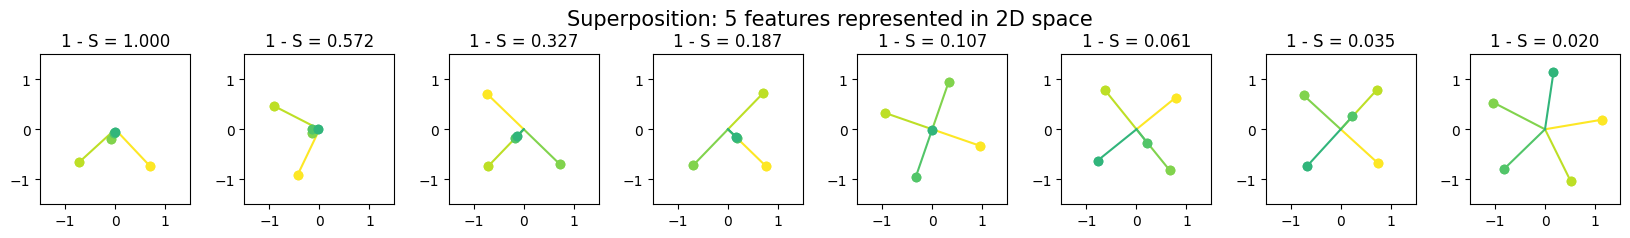

In [7]:
plot_features_in_2d(
    model.W,
    colors=model.importance,
    title=f"Superposition: {cfg.n_features} features represented in 2D space",
    subplot_titles=[f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
)

Interpretation:

